In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)


pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

- GÖREV 1 : Veri setine EDA işlemlerini uygulayınız.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

train = pd.read_csv("/content/drive/MyDrive/Dataset/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Dataset/test.csv")

Mounted at /content/drive


In [5]:
df = train.append(test,ignore_index=False).reset_index()

In [6]:
df = df.drop("index", axis=1)

In [7]:
############################################################################
# Genel Resim
############################################################################

In [8]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [9]:
check_df(df)

##################### Shape #####################
(2919, 81)
##################### Types #####################
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 81, dtype: object
##################### Head #####################
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities  \
0   1          60       RL       65.000     8450   Pave   NaN      Reg         Lvl    AllPub   
1   2          20       RL       80.000     9600   Pave   NaN      Reg         Lvl    AllPub   
2   3          60       RL       68.000    11250   Pave   NaN      IR1         Lvl    AllPub   

  LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  \
0    Inside       Gtl      CollgCr       Norm       Norm     

In [10]:
############################################################################
#  NUMERİK VE KATEGORİK DEĞİŞKENLERİN YAKALANMASI
############################################################################

In [11]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    # cat_cols + num_cols + cat_but_car = değişken sayısı.
    # num_but_cat cat_cols'un içerisinde zaten.
    # dolayısıyla tüm şu 3 liste ile tüm değişkenler seçilmiş olacaktır: cat_cols + num_cols + cat_but_car
    # num_but_cat sadece raporlama için verilmiştir.

    return cat_cols, cat_but_car, num_cols

In [12]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 2919
Variables: 81
cat_cols: 52
num_cols: 28
cat_but_car: 1
num_but_cat: 10


In [13]:
############################################################################
# 2. Kategorik Değişken Analizi (Analysis of Categorical Variables)
############################################################################

In [14]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

In [15]:
for col in cat_cols:
    cat_summary(df, col)

         MSZoning  Ratio
RL           2265 77.595
RM            460 15.759
FV            139  4.762
RH             26  0.891
C (all)        25  0.856
      Street  Ratio
Pave    2907 99.589
Grvl      12  0.411
      Alley  Ratio
Grvl    120  4.111
Pave     78  2.672
     LotShape  Ratio
Reg      1859 63.686
IR1       968 33.162
IR2        76  2.604
IR3        16  0.548
     LandContour  Ratio
Lvl         2622 89.825
HLS          120  4.111
Bnk          117  4.008
Low           60  2.055
        Utilities  Ratio
AllPub       2916 99.897
NoSeWa          1  0.034
         LotConfig  Ratio
Inside        2133 73.073
Corner         511 17.506
CulDSac        176  6.029
FR2             85  2.912
FR3             14  0.480
     LandSlope  Ratio
Gtl       2778 95.170
Mod        125  4.282
Sev         16  0.548
        Condition1  Ratio
Norm          2511 86.023
Feedr          164  5.618
Artery          92  3.152
RRAn            50  1.713
PosN            39  1.336
RRAe            28  0.959
PosA   

In [16]:
############################################################################
# 3. Sayısal Değişken Analizi (Analysis of Numerical Variables)
############################################################################

count   2919.000
mean    1460.000
std      842.787
min        1.000
5%       146.900
10%      292.800
20%      584.600
30%      876.400
40%     1168.200
50%     1460.000
60%     1751.800
70%     2043.600
80%     2335.400
90%     2627.200
95%     2773.100
99%     2889.820
max     2919.000
Name: Id, dtype: float64


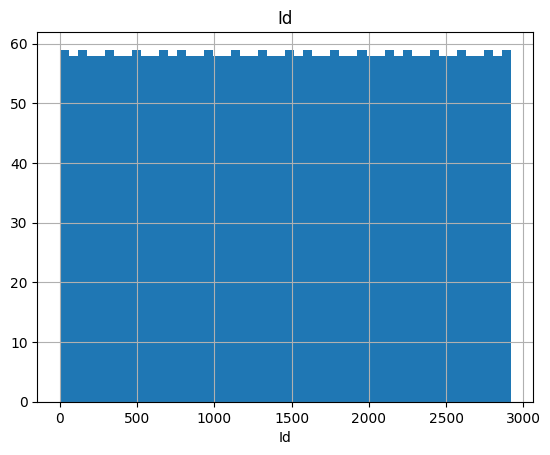

#####################################
count   2919.000
mean      57.138
std       42.518
min       20.000
5%        20.000
10%       20.000
20%       20.000
30%       20.000
40%       30.000
50%       50.000
60%       60.000
70%       60.000
80%       80.000
90%      120.000
95%      160.000
99%      190.000
max      190.000
Name: MSSubClass, dtype: float64


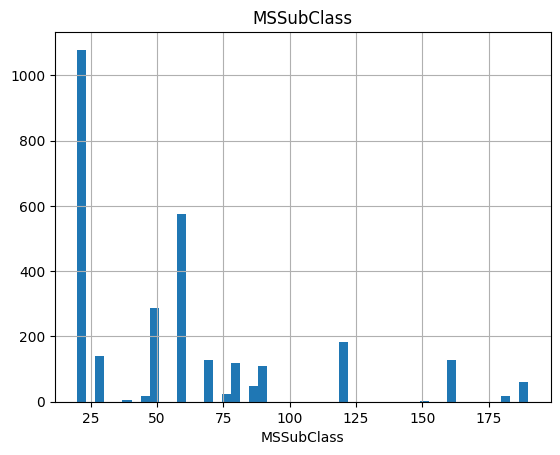

#####################################
count   2433.000
mean      69.306
std       23.345
min       21.000
5%        32.000
10%       43.000
20%       53.000
30%       60.000
40%       63.000
50%       68.000
60%       73.000
70%       78.000
80%       84.000
90%       95.000
95%      107.000
99%      135.680
max      313.000
Name: LotFrontage, dtype: float64


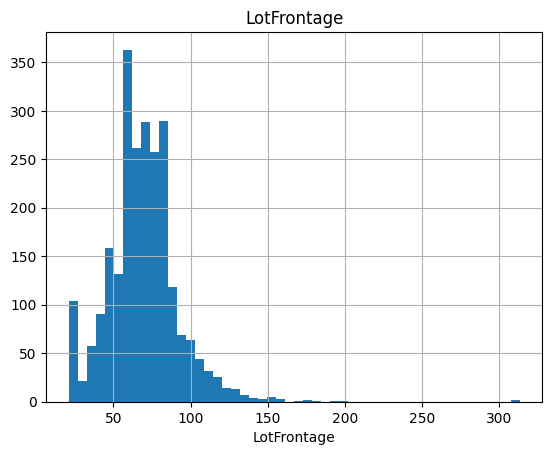

#####################################
count     2919.000
mean     10168.114
std       7886.996
min       1300.000
5%        3182.000
10%       4922.400
20%       7007.600
30%       7960.400
40%       8741.000
50%       9453.000
60%      10151.600
70%      11001.200
80%      12203.800
90%      14300.600
95%      17142.900
99%      33038.640
max     215245.000
Name: LotArea, dtype: float64


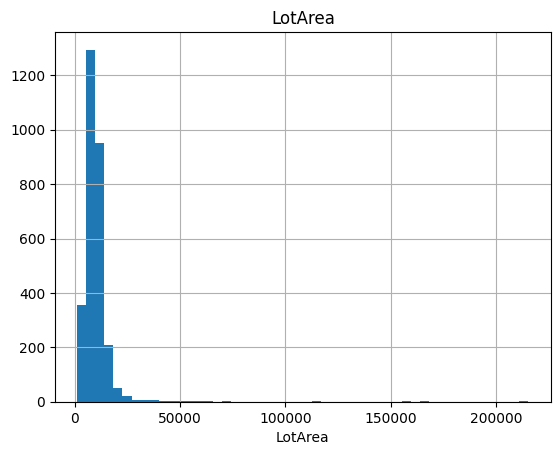

#####################################
count   2919.000
mean       6.089
std        1.410
min        1.000
5%         4.000
10%        5.000
20%        5.000
30%        5.000
40%        6.000
50%        6.000
60%        6.000
70%        7.000
80%        7.000
90%        8.000
95%        8.000
99%       10.000
max       10.000
Name: OverallQual, dtype: float64


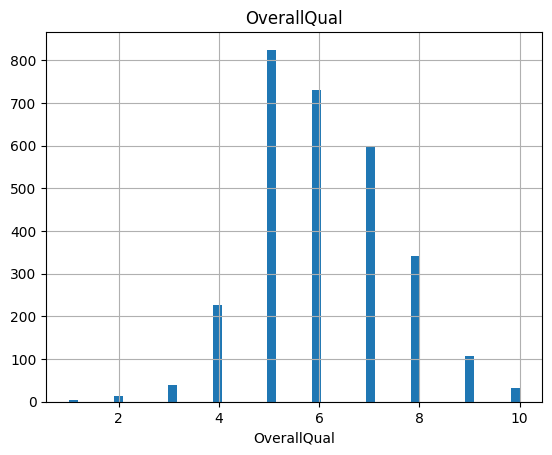

#####################################
count   2919.000
mean    1971.313
std       30.291
min     1872.000
5%      1915.000
10%     1924.000
20%     1947.000
30%     1957.000
40%     1965.000
50%     1973.000
60%     1984.000
70%     1998.000
80%     2003.000
90%     2006.000
95%     2007.000
99%     2008.000
max     2010.000
Name: YearBuilt, dtype: float64


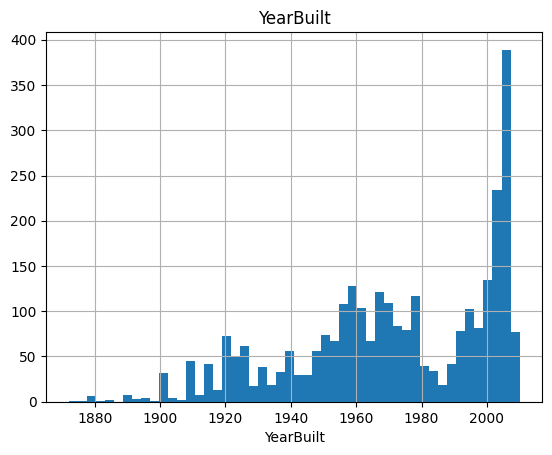

#####################################
count   2919.000
mean    1984.264
std       20.894
min     1950.000
5%      1950.000
10%     1950.000
20%     1960.000
30%     1970.000
40%     1978.000
50%     1993.000
60%     1998.000
70%     2002.000
80%     2005.000
90%     2006.200
95%     2007.000
99%     2009.000
max     2010.000
Name: YearRemodAdd, dtype: float64


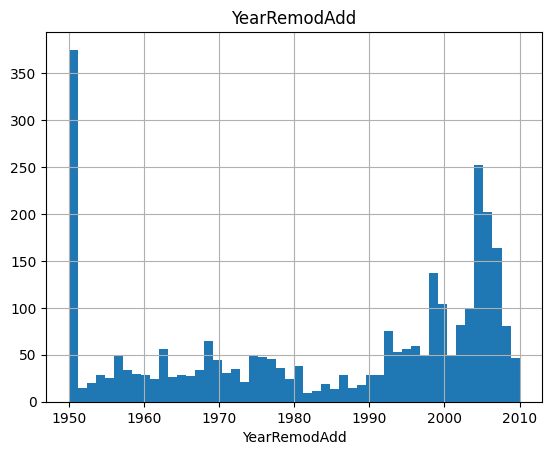

#####################################
count   2896.000
mean     102.201
std      179.334
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%      120.000
80%      202.000
90%      325.500
95%      466.500
99%      771.050
max     1600.000
Name: MasVnrArea, dtype: float64


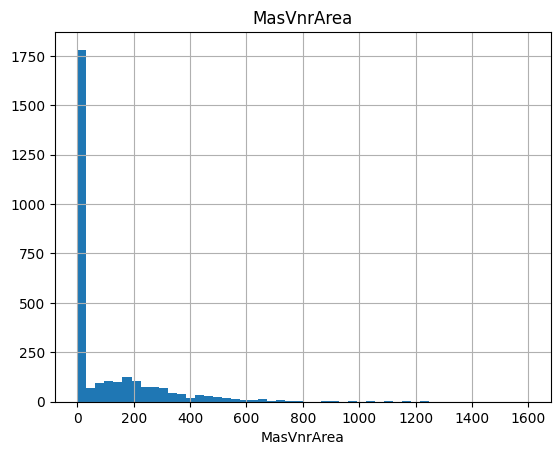

#####################################
count   2918.000
mean     441.423
std      455.611
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%      202.600
50%      368.500
60%      515.200
70%      656.000
80%      812.000
90%     1056.900
95%     1274.000
99%     1635.320
max     5644.000
Name: BsmtFinSF1, dtype: float64


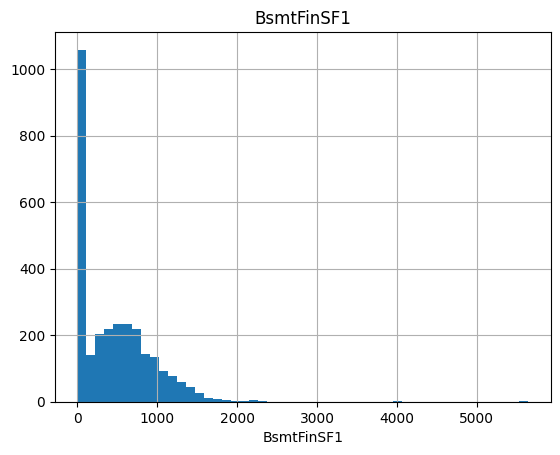

#####################################
count   2918.000
mean      49.582
std      169.206
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%      125.600
95%      435.000
99%      874.660
max     1526.000
Name: BsmtFinSF2, dtype: float64


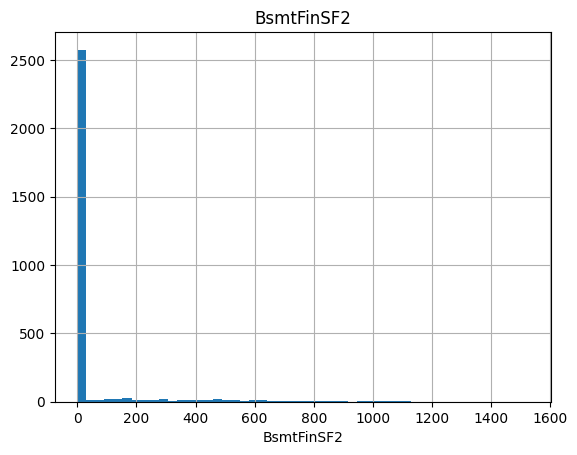

#####################################
count   2918.000
mean     560.772
std      439.544
min        0.000
5%         0.000
10%       56.000
20%      174.000
30%      270.000
40%      365.800
50%      467.000
60%      595.000
70%      732.000
80%      892.600
90%     1212.600
95%     1474.900
99%     1776.490
max     2336.000
Name: BsmtUnfSF, dtype: float64


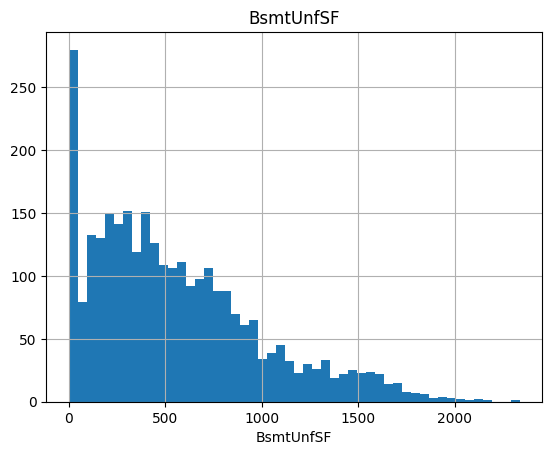

#####################################
count   2918.000
mean    1051.778
std      440.766
min        0.000
5%       455.250
10%      600.000
20%      741.000
30%      836.000
40%      911.000
50%      989.500
60%     1089.200
70%     1216.000
80%     1392.000
90%     1614.000
95%     1776.150
99%     2198.300
max     6110.000
Name: TotalBsmtSF, dtype: float64


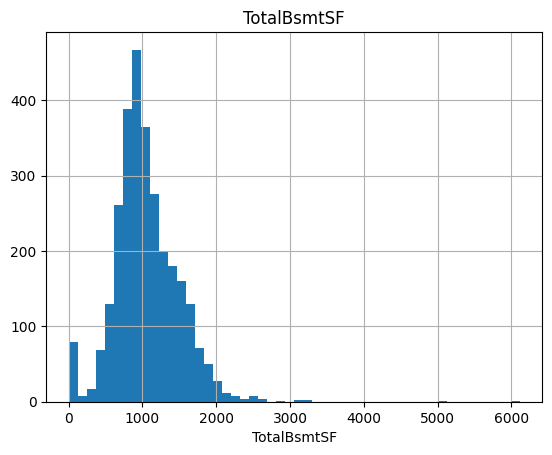

#####################################
count   2919.000
mean    1159.582
std      392.362
min      334.000
5%       665.900
10%      744.800
20%      847.000
30%      914.000
40%      996.200
50%     1082.000
60%     1180.000
70%     1314.000
80%     1483.400
90%     1675.000
95%     1830.100
99%     2288.020
max     5095.000
Name: 1stFlrSF, dtype: float64


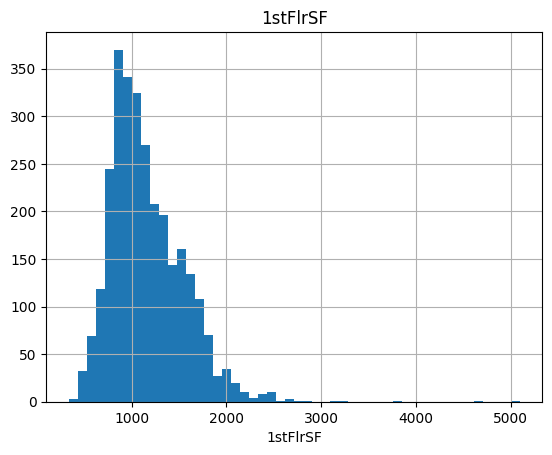

#####################################
count   2919.000
mean     336.484
std      428.701
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%      427.400
70%      636.000
80%      770.800
90%      925.000
95%     1131.200
99%     1400.200
max     2065.000
Name: 2ndFlrSF, dtype: float64


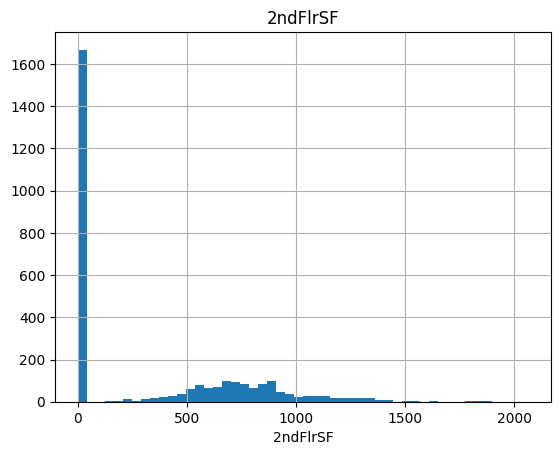

#####################################
count   2919.000
mean       4.694
std       46.397
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%      153.840
max     1064.000
Name: LowQualFinSF, dtype: float64


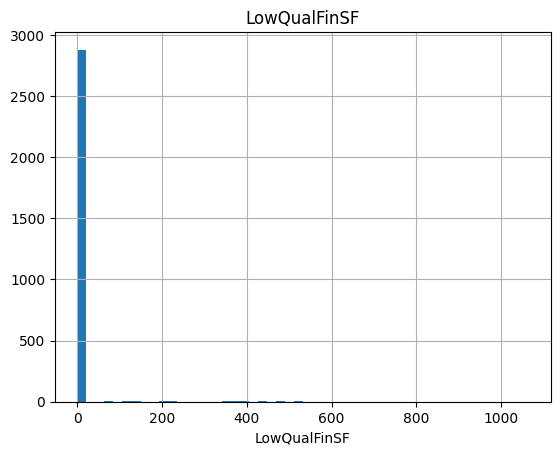

#####################################
count   2919.000
mean    1500.760
std      506.051
min      334.000
5%       861.000
10%      923.800
20%     1064.600
30%     1200.000
40%     1329.200
50%     1444.000
60%     1560.000
70%     1680.000
80%     1838.400
90%     2153.200
95%     2464.200
99%     2935.720
max     5642.000
Name: GrLivArea, dtype: float64


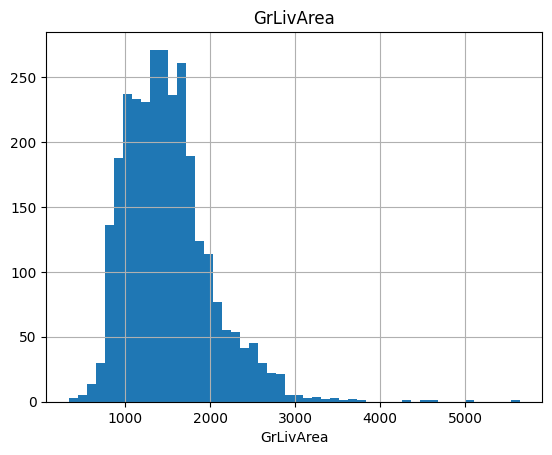

#####################################
count   2919.000
mean       6.452
std        1.569
min        2.000
5%         4.000
10%        5.000
20%        5.000
30%        6.000
40%        6.000
50%        6.000
60%        7.000
70%        7.000
80%        8.000
90%        8.000
95%        9.000
99%       11.000
max       15.000
Name: TotRmsAbvGrd, dtype: float64


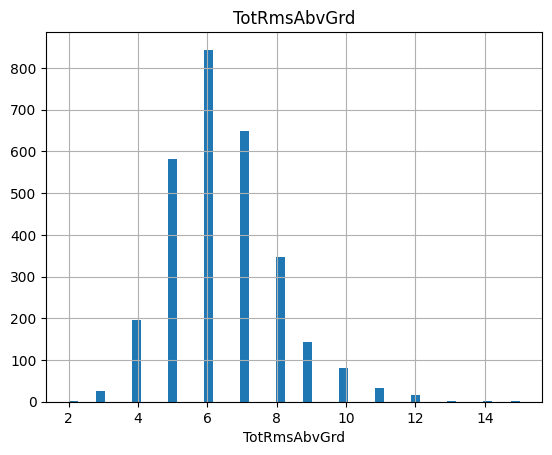

#####################################
count   2760.000
mean    1978.113
std       25.574
min     1895.000
5%      1928.000
10%     1941.000
20%     1957.000
30%     1964.000
40%     1972.000
50%     1979.000
60%     1993.000
70%     1999.000
80%     2004.000
90%     2006.000
95%     2007.000
99%     2009.000
max     2207.000
Name: GarageYrBlt, dtype: float64


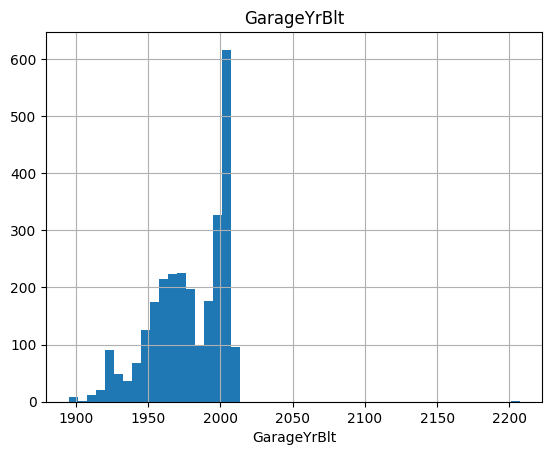

#####################################
count   2918.000
mean     472.875
std      215.395
min        0.000
5%         0.000
10%      240.000
20%      296.000
30%      379.000
40%      440.000
50%      480.000
60%      513.000
70%      560.900
80%      621.000
90%      758.000
95%      856.150
99%     1019.490
max     1488.000
Name: GarageArea, dtype: float64


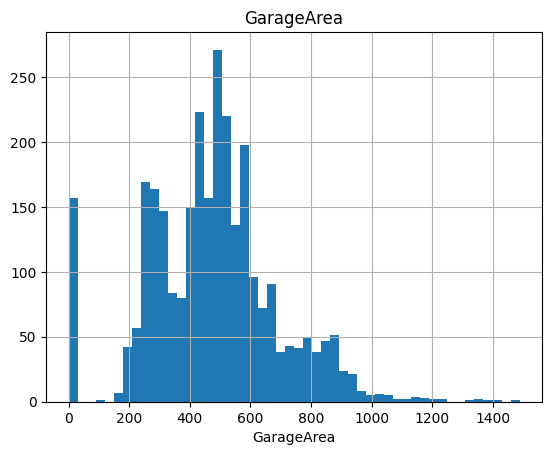

#####################################
count   2919.000
mean      93.710
std      126.527
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%      100.000
70%      144.000
80%      192.000
90%      257.000
95%      328.000
99%      500.820
max     1424.000
Name: WoodDeckSF, dtype: float64


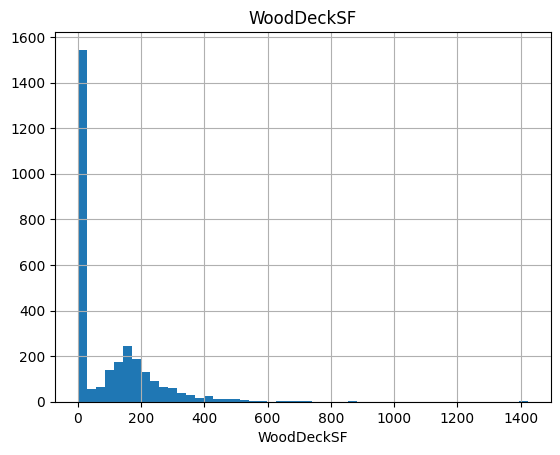

#####################################
count   2919.000
mean      47.487
std       67.575
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%       26.000
60%       40.000
70%       58.000
80%       85.000
90%      131.200
95%      183.100
99%      284.460
max      742.000
Name: OpenPorchSF, dtype: float64


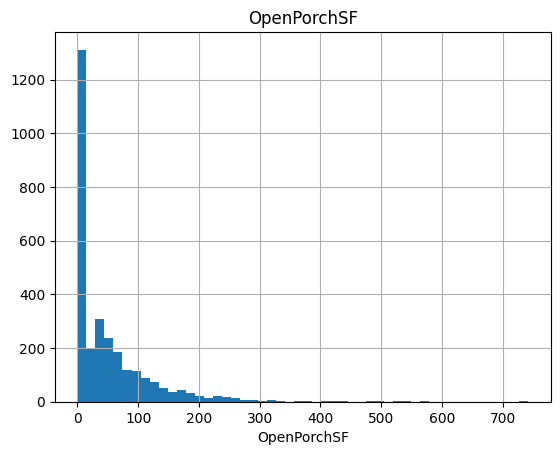

#####################################
count   2919.000
mean      23.098
std       64.244
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%      112.000
95%      176.000
99%      264.000
max     1012.000
Name: EnclosedPorch, dtype: float64


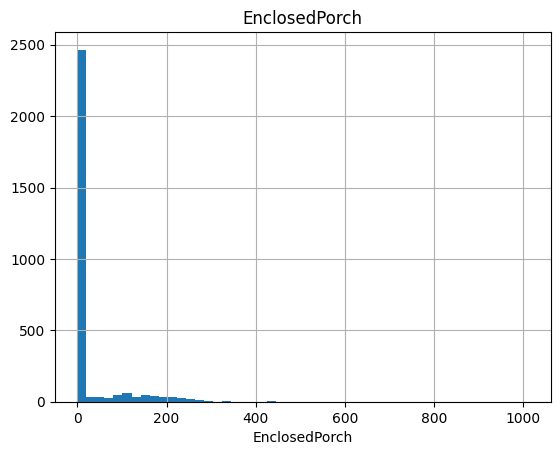

#####################################
count   2919.000
mean       2.602
std       25.188
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%      144.000
max      508.000
Name: 3SsnPorch, dtype: float64


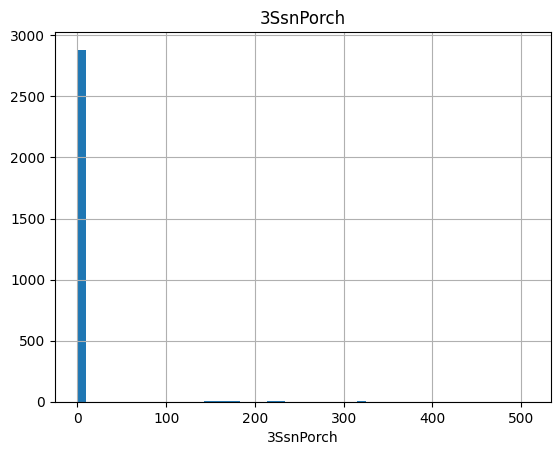

#####################################
count   2919.000
mean      16.062
std       56.184
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%      161.000
99%      259.820
max      576.000
Name: ScreenPorch, dtype: float64


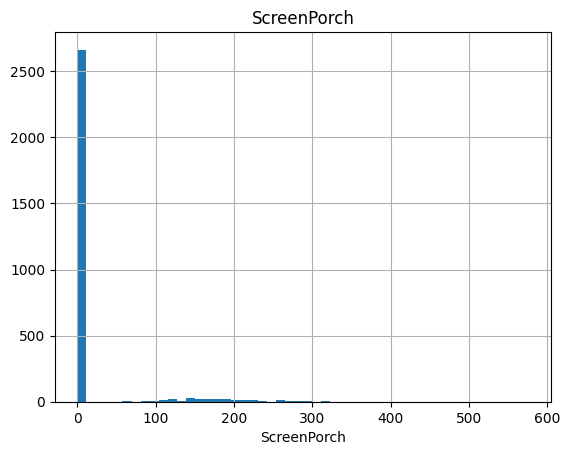

#####################################
count   2919.000
mean       2.252
std       35.664
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%        0.000
max      800.000
Name: PoolArea, dtype: float64


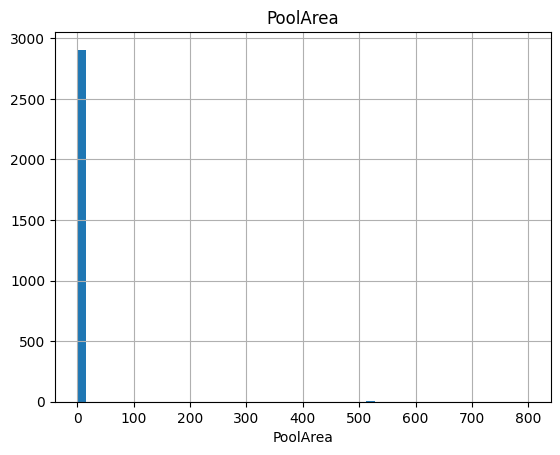

#####################################
count    2919.000
mean       50.826
std       567.402
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.000
99%       982.000
max     17000.000
Name: MiscVal, dtype: float64


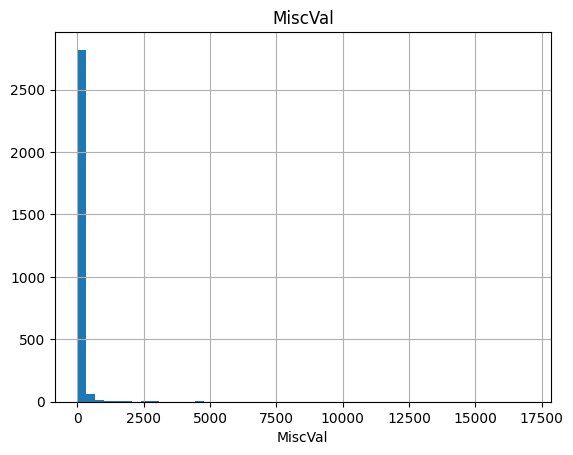

#####################################
count   2919.000
mean       6.213
std        2.715
min        1.000
5%         2.000
10%        3.000
20%        4.000
30%        5.000
40%        6.000
50%        6.000
60%        7.000
70%        7.000
80%        8.000
90%       10.000
95%       11.000
99%       12.000
max       12.000
Name: MoSold, dtype: float64


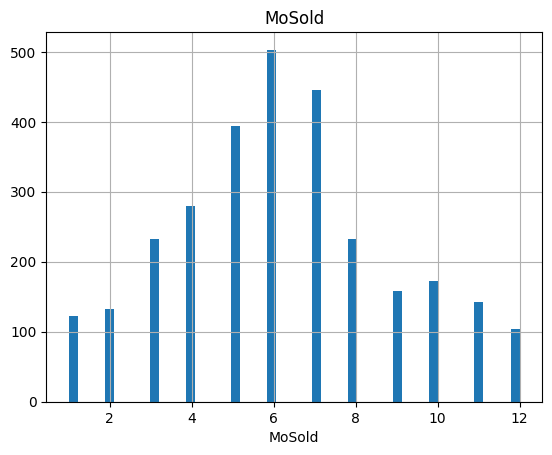

#####################################
count     1460.000
mean    180921.196
std      79442.503
min      34900.000
5%       88000.000
10%     106475.000
20%     124000.000
30%     135500.000
40%     147000.000
50%     163000.000
60%     179280.000
70%     198620.000
80%     230000.000
90%     278000.000
95%     326100.000
99%     442567.010
max     755000.000
Name: SalePrice, dtype: float64


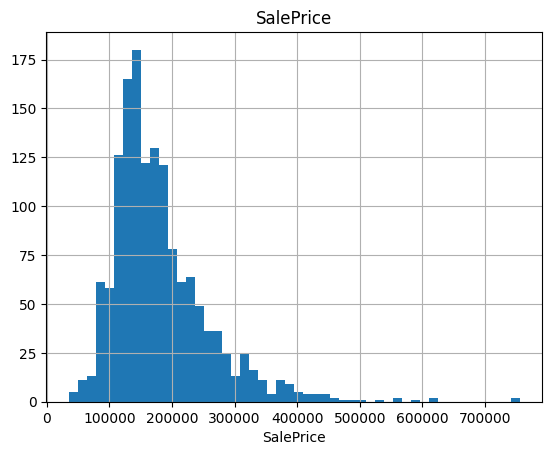

#####################################


In [17]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")


for col in num_cols:
    num_summary(df, col,True)

In [18]:
############################################################################
# 4. Hedef Değişken Analizi (Analysis of Target Variable)
############################################################################

In [19]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


for col in cat_cols:
    target_summary_with_cat(df,"SalePrice",col)

          TARGET_MEAN
MSZoning             
C (all)     74528.000
FV         214014.062
RH         131558.375
RL         191004.995
RM         126316.830


        TARGET_MEAN
Street             
Grvl     130190.500
Pave     181130.539


       TARGET_MEAN
Alley             
Grvl    122219.080
Pave    168000.585


          TARGET_MEAN
LotShape             
IR1        206101.665
IR2        239833.366
IR3        216036.500
Reg        164754.818


             TARGET_MEAN
LandContour             
Bnk           143104.079
HLS           231533.940
Low           203661.111
Lvl           180183.747


           TARGET_MEAN
Utilities             
AllPub      180950.957
NoSeWa      137500.000


           TARGET_MEAN
LotConfig             
Corner      181623.426
CulDSac     223854.617
FR2         177934.574
FR3         208475.000
Inside      176938.048


           TARGET_MEAN
LandSlope             
Gtl         179956.800
Mod         196734.138
Sev         204379.231


            TARGET_MEAN


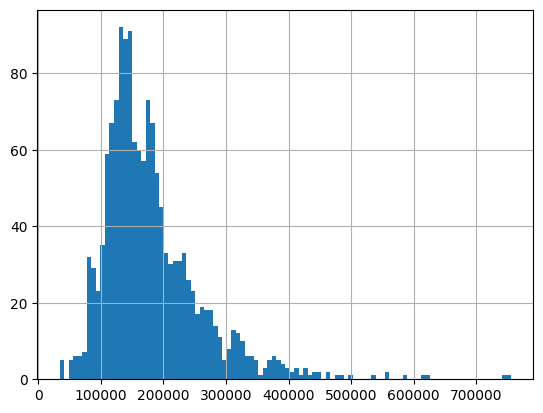

In [20]:
# Bağımlı değişkenin incelenmesi
df["SalePrice"].hist(bins=100)
plt.show()

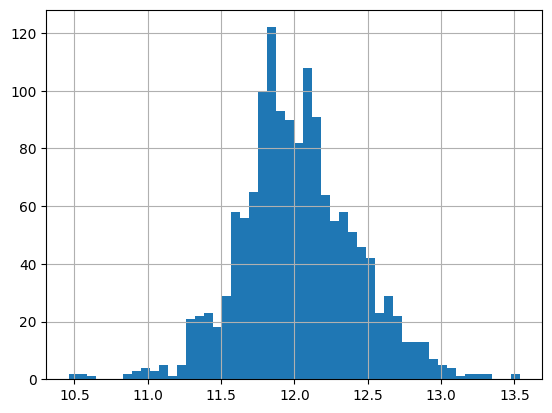

In [21]:
# Bağımlı değişkenin logaritmasının incelenmesi
np.log1p(df['SalePrice']).hist(bins=50)
plt.show()

In [22]:
#################################################
# 5. Korelasyon Analizi (Analysis of Correlation)
#################################################

In [23]:
corr = df[num_cols].corr()

In [24]:
corr

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,TotRmsAbvGrd,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice
Id,1.000,0.009,-0.028,-0.041,-0.030,-0.017,-0.050,-0.025,-0.017,0.018,-0.014,-0.025,-0.009,-0.022,-0.038,-0.029,-0.029,-0.027,-0.009,-0.007,0.010,0.022,-0.047,0.022,0.014,0.008,0.006,-0.022
MSSubClass,0.009,1.000,-0.417,-0.202,0.034,0.034,0.043,0.005,-0.064,-0.073,-0.126,-0.220,-0.249,0.309,0.026,0.072,0.041,0.088,-0.103,-0.018,-0.016,-0.021,-0.038,-0.049,-0.003,-0.029,-0.001,-0.084
LotFrontage,-0.028,-0.417,1.000,0.490,0.218,0.123,0.092,0.221,0.219,0.047,0.114,0.355,0.458,0.027,0.005,0.382,0.350,0.077,0.360,0.122,0.165,0.012,0.028,0.076,0.174,0.044,0.011,0.352
LotArea,-0.041,-0.202,0.490,1.000,0.101,0.024,0.022,0.126,0.194,0.084,0.021,0.254,0.332,0.032,0.001,0.285,0.214,-0.009,0.213,0.158,0.105,0.021,0.016,0.054,0.094,0.069,0.004,0.264
OverallQual,-0.030,0.034,0.218,0.101,1.000,0.598,0.572,0.433,0.282,-0.043,0.275,0.549,0.479,0.246,-0.048,0.575,0.390,0.572,0.565,0.255,0.298,-0.139,0.019,0.043,0.031,0.006,0.030,0.791
YearBuilt,-0.017,0.034,0.123,0.024,0.598,1.000,0.612,0.314,0.280,-0.028,0.130,0.409,0.311,0.018,-0.144,0.243,0.114,0.835,0.481,0.229,0.199,-0.374,0.016,-0.041,0.002,-0.011,0.014,0.523
YearRemodAdd,-0.050,0.043,0.092,0.022,0.572,0.612,1.000,0.197,0.152,-0.062,0.165,0.298,0.242,0.159,-0.060,0.317,0.198,0.652,0.377,0.219,0.242,-0.220,0.037,-0.047,-0.011,-0.003,0.018,0.507
MasVnrArea,-0.025,0.005,0.221,0.126,0.433,0.314,0.197,1.000,0.303,-0.016,0.090,0.397,0.396,0.121,-0.058,0.403,0.278,0.255,0.374,0.166,0.145,-0.111,0.014,0.065,0.005,0.045,-0.000,0.477
BsmtFinSF1,-0.017,-0.064,0.219,0.194,0.282,0.280,0.152,0.303,1.000,-0.055,-0.477,0.536,0.458,-0.162,-0.066,0.212,0.052,0.194,0.310,0.223,0.124,-0.100,0.051,0.097,0.084,0.093,-0.001,0.386
BsmtFinSF2,0.018,-0.073,0.047,0.084,-0.043,-0.028,-0.062,-0.016,-0.055,1.000,-0.238,0.089,0.084,-0.098,-0.005,-0.018,-0.048,-0.069,0.003,0.098,-0.006,0.033,-0.023,0.063,0.045,-0.005,-0.010,-0.011


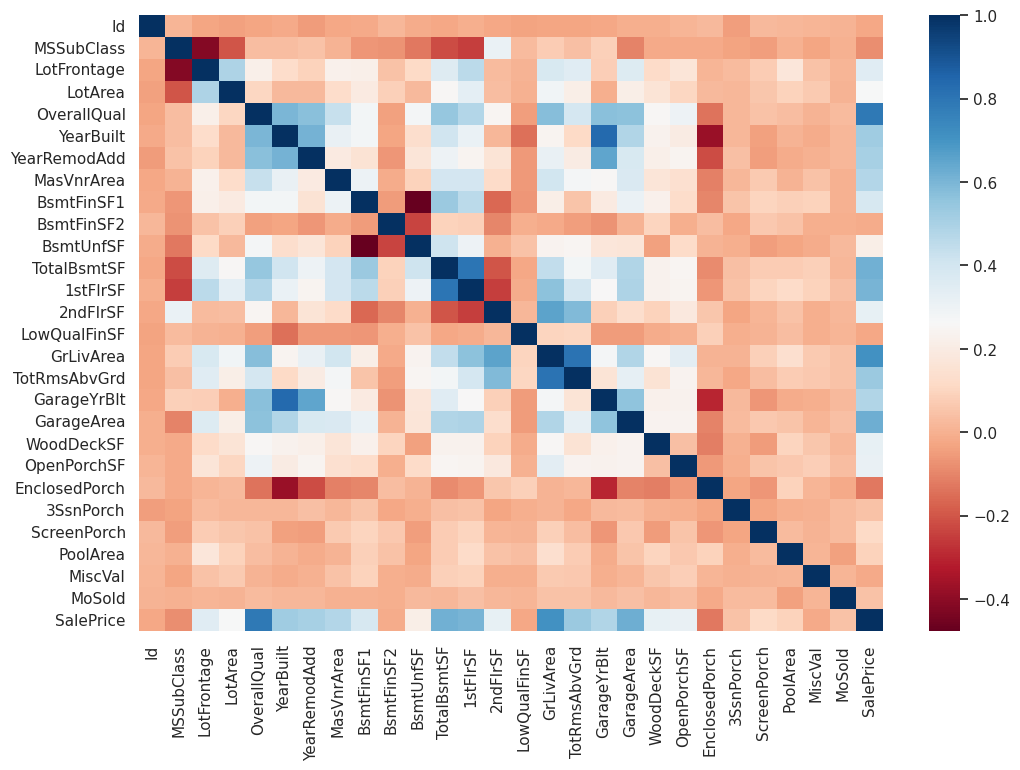

In [25]:
# Korelasyonların gösterilmesi
sns.set(rc={'figure.figsize': (12,8)})
sns.heatmap(corr, cmap="RdBu")
plt.show()

In [26]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (8,8)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

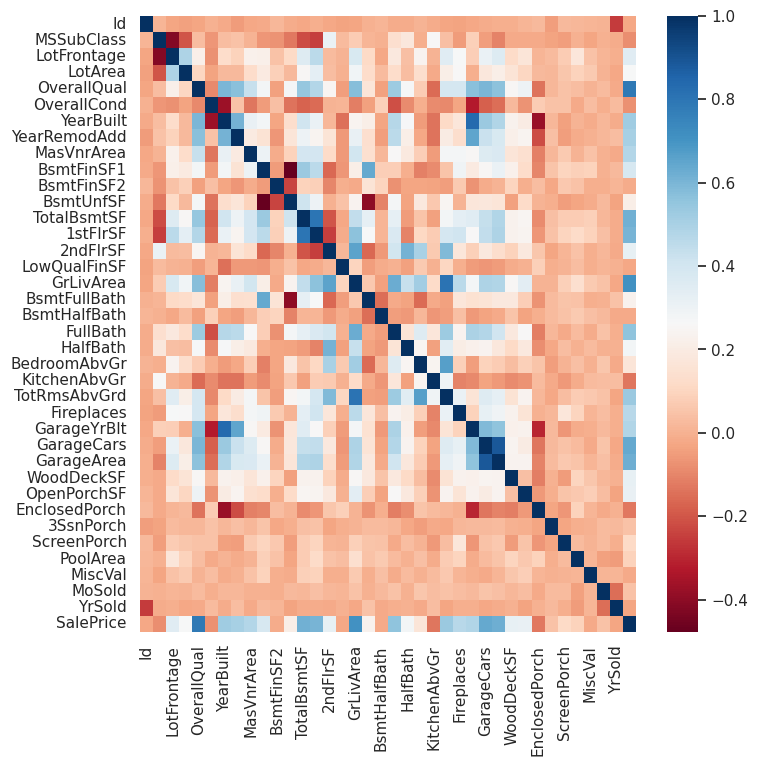

['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'SalePrice']

In [27]:
high_correlated_cols(df, plot=True)

In [28]:
######################################
# Görev 2 : Feature Engineering
######################################

In [29]:
######################################
# Aykırı Değer Analizi
######################################

In [30]:
# Aykırı değerlerin baskılanması

In [31]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

In [32]:
# Aykırı değer kontrolü
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [33]:
for col in num_cols:
    if col != "SalePrice":
      print(col, check_outlier(df, col))

Id False
MSSubClass False
LotFrontage True
LotArea True
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea True
BsmtFinSF1 True
BsmtFinSF2 True
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea True
TotRmsAbvGrd True
GarageYrBlt True
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch True
PoolArea True
MiscVal True
MoSold False


In [34]:
# Aykırı değerlerin baskılanması
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [35]:
for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df,col)

In [36]:
######################################
# Eksik Değer Analizi
######################################

In [37]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [38]:
missing_values_table(df)

              n_miss  ratio
PoolQC          2909 99.660
MiscFeature     2814 96.400
Alley           2721 93.220
Fence           2348 80.440
SalePrice       1459 49.980
FireplaceQu     1420 48.650
LotFrontage      486 16.650
GarageCond       159  5.450
GarageYrBlt      159  5.450
GarageFinish     159  5.450
GarageQual       159  5.450
GarageType       157  5.380
BsmtExposure      82  2.810
BsmtCond          82  2.810
BsmtQual          81  2.770
BsmtFinType2      80  2.740
BsmtFinType1      79  2.710
MasVnrType        24  0.820
MasVnrArea        23  0.790
MSZoning           4  0.140
Functional         2  0.070
BsmtHalfBath       2  0.070
BsmtFullBath       2  0.070
Utilities          2  0.070
KitchenQual        1  0.030
TotalBsmtSF        1  0.030
BsmtUnfSF          1  0.030
GarageCars         1  0.030
GarageArea         1  0.030
BsmtFinSF2         1  0.030
BsmtFinSF1         1  0.030
Exterior2nd        1  0.030
Exterior1st        1  0.030
SaleType           1  0.030
Electrical         1

In [39]:
df["Alley"].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

In [40]:
df["BsmtQual"].value_counts()

TA    1283
Gd    1209
Ex     258
Fa      88
Name: BsmtQual, dtype: int64

In [41]:
 #Bazı değişkenlerdeki boş değerler evin o özelliğe sahip olmadığını ifade etmektedir
no_cols = ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
           "GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]

In [42]:
# Kolonlardaki boşlukların "No" ifadesi ile doldurulması
for col in no_cols:
    df[col].fillna("No",inplace=True)

In [43]:
missing_values_table(df)

              n_miss  ratio
SalePrice       1459 49.980
LotFrontage      486 16.650
GarageYrBlt      159  5.450
MasVnrType        24  0.820
MasVnrArea        23  0.790
MSZoning           4  0.140
BsmtFullBath       2  0.070
BsmtHalfBath       2  0.070
Functional         2  0.070
Utilities          2  0.070
Exterior2nd        1  0.030
BsmtFinSF1         1  0.030
BsmtFinSF2         1  0.030
BsmtUnfSF          1  0.030
Exterior1st        1  0.030
Electrical         1  0.030
KitchenQual        1  0.030
GarageCars         1  0.030
GarageArea         1  0.030
SaleType           1  0.030
TotalBsmtSF        1  0.030


In [44]:
# Bu fonsksiyon eksik değerlerin median veya mean ile doldurulmasını sağlar

def quick_missing_imp(data, num_method="median", cat_length=20, target="SalePrice"):
    variables_with_na = [col for col in data.columns if data[col].isnull().sum() > 0]  # Eksik değere sahip olan değişkenler listelenir

    temp_target = data[target]

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    # değişken object ve sınıf sayısı cat_lengthe eşit veya altındaysa boş değerleri mode ile doldur
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)

    # num_method mean ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    # num_method median ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    data[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data

In [45]:
df = quick_missing_imp(df, num_method="median", cat_length=17)

# BEFORE
MSZoning           4
LotFrontage      486
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
GarageYrBlt      159
GarageCars         1
GarageArea         1
SaleType           1
SalePrice       1459
dtype: int64 


# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

MSZoning           0
LotFrontage        0
Utilities          0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         0
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Electrical         0
BsmtFullBath       0
BsmtHalfBath       0
KitchenQual        0
Functional         0
GarageYrBlt        0
GarageCars         0
GarageArea         0
SaleType      

In [46]:
######################################
# Rare analizi yapınız ve rare encoder uygulayınız.
######################################

In [47]:
# Kategorik kolonların dağılımının incelenmesi

In [48]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [49]:
rare_analyser(df, "SalePrice", cat_cols)

MSZoning : 5
         COUNT  RATIO  TARGET_MEAN
C (all)     25  0.009    74528.000
FV         139  0.048   214014.062
RH          26  0.009   131558.375
RL        2269  0.777   191004.995
RM         460  0.158   126316.830


Street : 2
      COUNT  RATIO  TARGET_MEAN
Grvl     12  0.004   130190.500
Pave   2907  0.996   181130.539


Alley : 3
      COUNT  RATIO  TARGET_MEAN
Grvl    120  0.041   122219.080
No     2721  0.932   183452.131
Pave     78  0.027   168000.585


LotShape : 4
     COUNT  RATIO  TARGET_MEAN
IR1    968  0.332   206101.665
IR2     76  0.026   239833.366
IR3     16  0.005   216036.500
Reg   1859  0.637   164754.818


LandContour : 4
     COUNT  RATIO  TARGET_MEAN
Bnk    117  0.040   143104.079
HLS    120  0.041   231533.940
Low     60  0.021   203661.111
Lvl   2622  0.898   180183.747


Utilities : 2
        COUNT  RATIO  TARGET_MEAN
AllPub   2918  1.000   180950.957
NoSeWa      1  0.000   137500.000


LotConfig : 5
         COUNT  RATIO  TARGET_MEAN
Corner     511  

In [50]:
# Nadir sınıfların tespit edilmesi
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [51]:
rare_encoder(df,0.01)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.000,60,RL,65.000,8450.000,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.000,5,2003,2003.000,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706.000,Unf,0.000,150.000,856.000,GasA,Ex,Y,SBrkr,856.000,854.000,0,1710.000,1.000,0.000,2,1,3,1,Gd,8.000,Typ,0,No,Attchd,2003.000,RFn,2.000,548.000,TA,TA,Y,0.000,61.000,0,0,0,0,No,No,No,0,2.000,2008,WD,Normal,208500.000
1,2.000,20,RL,80.000,9600.000,Pave,No,Reg,Lvl,AllPub,FR2,Gtl,Rare,Feedr,Norm,1Fam,1Story,6.000,8,1976,1976.000,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.000,Unf,0.000,284.000,1262.000,GasA,Ex,Y,SBrkr,1262.000,0.000,0,1262.000,0.000,1.000,2,0,3,1,TA,6.000,Typ,1,TA,Attchd,1976.000,RFn,2.000,460.000,TA,TA,Y,298.000,0.000,0,0,0,0,No,No,No,0,5.000,2007,WD,Normal,181500.000
2,3.000,60,RL,68.000,11250.000,Pave,No,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.000,5,2001,2002.000,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.000,Unf,0.000,434.000,920.000,GasA,Ex,Y,SBrkr,920.000,866.000,0,1786.000,1.000,0.000,2,1,3,1,Gd,6.000,Typ,1,TA,Attchd,2001.000,RFn,2.000,608.000,TA,TA,Y,0.000,42.000,0,0,0,0,No,No,No,0,9.000,2008,WD,Normal,223500.000
3,4.000,70,RL,60.000,9550.000,Pave,No,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.000,5,1915,1970.000,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216.000,Unf,0.000,540.000,756.000,GasA,Gd,Y,SBrkr,961.000,756.000,0,1717.000,1.000,0.000,1,0,3,1,Gd,7.000,Typ,1,Gd,Detchd,1998.000,Unf,3.000,642.000,TA,TA,Y,0.000,35.000,272,0,0,0,No,No,No,0,2.000,2006,WD,Abnorml,140000.000
4,5.000,60,RL,84.000,14260.000,Pave,No,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.000,5,2000,2000.000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655.000,Unf,0.000,490.000,1145.000,GasA,Ex,Y,SBrkr,1145.000,1053.000,0,2198.000,1.000,0.000,2,1,4,1,Gd,9.000,Typ,1,TA,Attchd,2000.000,RFn,3.000,836.000,TA,TA,Y,192.000,84.000,0,0,0,0,No,No,No,0,12.000,2008,WD,Normal,250000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915.000,160,RM,21.000,1936.000,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4.000,7,1970,1970.000,Gable,CompShg,CemntBd,CmentBd,None,0.000,TA,TA,CBlock,TA,TA,No,Unf,0.000,Unf,0.000,546.000,546.000,GasA,Gd,Y,SBrkr,546.000,546.000,0,1092.000,0.000,0.000,1,1,3,1,TA,5.000,Typ,0,No,No,1979.000,No,0.000,0.000,No,No,Y,0.000,0.000,0,0,0,0,No,No,No,0,6.000,2006,WD,Normal,NaN
2915,2916.000,160,RM,21.000,1894.000,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4.000,5,1970,1970.000,Gable,CompShg,CemntBd,CmentBd,None,0.000,TA,TA,CBlock,TA,TA,No,Rec,252.000,Unf,0.000,294.000,546.000,GasA,TA,Y,SBrkr,546.000,546.000,0,1092.000,0.000,0.000,1,1,3,1,TA,6.000,Typ,0,No,Rare,1970.000,Unf,1.000,286.000,TA,TA,Y,0.000,24.000,0,0,0,0,No,No,No,0,4.000,

In [52]:
######################################
# yeni değişkenler oluşturunuz ve oluşturduğunuz yeni değişkenlerin başına 'NEW' ekleyiniz.
######################################

In [53]:
df["NEW_1st*GrLiv"] = df["1stFlrSF"] * df["GrLivArea"]

In [54]:
df["NEW_Garage*GrLiv"] = (df["GarageArea"] * df["GrLivArea"])

In [55]:
df["TotalQual"] = df[["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtCond", "BsmtFinType1",
                      "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageQual", "GarageCond", "Fence"]].sum(axis = 1) # 42

In [56]:
# Total Floor
df["NEW_TotalFlrSF"] = df["1stFlrSF"] + df["2ndFlrSF"] # 32

In [57]:
# Total Finished Basement Area
df["NEW_TotalBsmtFin"] = df.BsmtFinSF1 + df.BsmtFinSF2 # 56

In [58]:
# Porch Area
df["NEW_PorchArea"] = df.OpenPorchSF + df.EnclosedPorch + df.ScreenPorch + df["3SsnPorch"] + df.WoodDeckSF # 93

In [59]:
# Total House Area
df["NEW_TotalHouseArea"] = df.NEW_TotalFlrSF + df.TotalBsmtSF # 156

In [60]:
df["NEW_TotalSqFeet"] = df.GrLivArea + df.TotalBsmtSF # 35

In [61]:
# Lot Ratio
df["NEW_LotRatio"] = df.GrLivArea / df.LotArea # 64

In [62]:
df["NEW_RatioArea"] = df.NEW_TotalHouseArea / df.LotArea # 57

In [63]:
df["NEW_GarageLotRatio"] = df.GarageArea / df.LotArea # 69

In [64]:
# MasVnrArea
df["NEW_MasVnrRatio"] = df.MasVnrArea / df.NEW_TotalHouseArea # 36

In [65]:
# Dif Area
df["NEW_DifArea"] = (df.LotArea - df["1stFlrSF"] - df.GarageArea - df.NEW_PorchArea - df.WoodDeckSF) # 73

In [66]:
df["NEW_OverallGrade"] = df["OverallQual"] * df["OverallCond"] # 61

In [67]:
df["NEW_Restoration"] = df.YearRemodAdd - df.YearBuilt # 31

In [68]:
df["NEW_HouseAge"] = df.YrSold - df.YearBuilt # 73

In [69]:
df["NEW_RestorationAge"] = df.YrSold - df.YearRemodAdd # 40

In [70]:
df["NEW_GarageAge"] = df.GarageYrBlt - df.YearBuilt # 17

In [71]:
df["NEW_GarageRestorationAge"] = np.abs(df.GarageYrBlt - df.YearRemodAdd) # 30

In [72]:
df["NEW_GarageSold"] = df.YrSold - df.GarageYrBlt # 48

In [73]:
drop_list = ["Street", "Alley", "LandContour", "Utilities", "LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood"]

In [74]:
# drop_list'teki değişkenlerin düşürülmesi
df.drop(drop_list, axis=1, inplace=True)

In [75]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,NEW_1st*GrLiv,NEW_Garage*GrLiv,TotalQual,NEW_TotalFlrSF,NEW_TotalBsmtFin,NEW_PorchArea,NEW_TotalHouseArea,NEW_TotalSqFeet,NEW_LotRatio,NEW_RatioArea,NEW_GarageLotRatio,NEW_MasVnrRatio,NEW_DifArea,NEW_OverallGrade,NEW_Restoration,NEW_HouseAge,NEW_RestorationAge,NEW_GarageAge,NEW_GarageRestorationAge,NEW_GarageSold
0,1.000,60,RL,65.000,8450.000,Reg,Inside,Norm,Norm,1Fam,2Story,7.000,5,2003,2003.000,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706.000,Unf,0.000,150.000,856.000,Ex,Y,SBrkr,856.000,854.000,0,1710.000,1.000,0.000,2,1,3,1,Gd,8.000,Typ,0,No,Attchd,2003.000,RFn,2.000,548.000,TA,TA,Y,0.000,61.000,0,0,0,0,No,0,2.000,2008,WD,Normal,208500.000,1463760.000,937080.000,12.000,1710.000,706.000,61.000,2566.000,2566.000,0.202,0.304,0.065,0.076,6985.000,35.000,0.000,5,5.000,0.000,0.000,5.000
1,2.000,20,RL,80.000,9600.000,Reg,FR2,Feedr,Norm,1Fam,1Story,6.000,8,1976,1976.000,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.000,Unf,0.000,284.000,1262.000,Ex,Y,SBrkr,1262.000,0.000,0,1262.000,0.000,1.000,2,0,3,1,TA,6.000,Typ,1,TA,Attchd,1976.000,RFn,2.000,460.000,TA,TA,Y,298.000,0.000,0,0,0,0,No,0,5.000,2007,WD,Normal,181500.000,1592644.000,580520.000,14.000,1262.000,978.000,298.000,2524.000,2524.000,0.131,0.263,0.048,0.000,7282.000,48.000,0.000,31,31.000,0.000,0.000,31.000
2,3.000,60,RL,68.000,11250.000,IR1,Inside,Norm,Norm,1Fam,2Story,7.000,5,2001,2002.000,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.000,Unf,0.000,434.000,920.000,Ex,Y,SBrkr,920.000,866.000,0,1786.000,1.000,0.000,2,1,3,1,Gd,6.000,Typ,1,TA,Attchd,2001.000,RFn,2.000,608.000,TA,TA,Y,0.000,42.000,0,0,0,0,No,0,9.000,2008,WD,Normal,223500.000,1643120.000,1085888.000,12.000,1786.000,486.000,42.000,2706.000,2706.000,0.159,0.241,0.054,0.060,9680.000,35.000,1.000,7,6.000,0.000,1.000,7.000
3,4.000,70,RL,60.000,9550.000,IR1,Corner,Norm,Norm,1Fam,2Story,7.000,5,1915,1970.000,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216.000,Unf,0.000,540.000,756.000,Gd,Y,SBrkr,961.000,756.000,0,1717.000,1.000,0.000,1,0,3,1,Gd,7.000,Typ,1,Gd,Detchd,1998.000,Unf,3.000,642.000,TA,TA,Y,0.000,35.000,272,0,0,0,No,0,2.000,2006,WD,Abnorml,140000.000,1650037.000,1102314.000,12.000,1717.000,216.000,307.000,2473.000,2473.000,0.180,0.259,0.067,0.000,7640.000,35.000,55.000,91,36.000,83.000,28.000,8.000
4,5.000,60,RL,84.000,14260.000,IR1,FR2,Norm,Norm,1Fam,2Story,8.000,5,2000,2000.000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655.000,Unf,0.000,490.000,1145.000,Ex,Y,SBrkr,1145.000,1053.000,0,2198.000,1.000,0.000,2,1,4,1,Gd,9.000,Typ,1,TA,Attchd,2000.000,RFn,3.000,836.000,TA,TA,Y,192.000,84.000,0,0,0,0,No,0,12.000,2008,WD,Normal,250000.000,2516710.000,1837528.000,13.000,2198.000,655.000,276.000,3343.000,3343.000,0.154,0.234,0.059,0.105,11811.000,40.000,0.000,8,8.000,0.000,0.000,8.000


In [76]:
######################################################
# Label Encoding & One-Hot Encoding işlemlerini uygulayınız.
######################################################

In [77]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 2919
Variables: 92
cat_cols: 49
num_cols: 43
cat_but_car: 0
num_but_cat: 15


In [78]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [79]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and len(df[col].unique()) == 2]

In [80]:
for col in binary_cols:
    label_encoder(df, col)

In [81]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [82]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [83]:
##################################
# MODELLEME
##################################

In [84]:
##################################
# GÖREV 3: Model kurma
##################################

In [85]:
#  Train ve Test verisini ayırınız. (SalePrice değişkeni boş olan değerler test verisidir.)
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

In [86]:
y = train_df['SalePrice'] # np.log1p(df['SalePrice'])
X = train_df.drop(["Id", "SalePrice"], axis=1)

In [87]:
# Train verisi ile model kurup, model başarısını değerlendiriniz.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [88]:
models = [('LR', LinearRegression()),
          #("Ridge", Ridge()),
          #("Lasso", Lasso()),
          #("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          #('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]
          # ("CatBoost", CatBoostRegressor(verbose=False))]

In [89]:
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 42501.7985 (LR) 
RMSE: 47557.3947 (KNN) 
RMSE: 38715.1799 (CART) 
RMSE: 29275.0647 (RF) 
RMSE: 25840.5026 (GBM) 
RMSE: 27971.7767 (XGBoost) 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6477
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 178
[LightGBM] [Info] Start training from score 180717.091610
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6479
[LightGBM] [Info] Numb

In [90]:
df['SalePrice'].mean()

180921.19589041095

In [91]:
df['SalePrice'].std()

79442.50288288662

In [92]:
##################
# BONUS : Log dönüşümü yaparak model kurunuz ve rmse sonuçlarını gözlemleyiniz.
# Not: Log'un tersini (inverse) almayı unutmayınız.
##################

In [93]:
# Log dönüşümünün gerçekleştirilmesi

In [94]:
train_df = df[df['SalePrice'].notnull()]

In [95]:
test_df = df[df['SalePrice'].isnull()]

In [96]:
y = np.log1p(train_df['SalePrice'])

In [97]:
X = train_df.drop(["Id", "SalePrice"], axis=1)

In [98]:
# Verinin eğitim ve tet verisi olarak bölünmesi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [99]:
# lgbm_tuned = LGBMRegressor(**lgbm_gs_best.best_params_).fit(X_train, y_train)

In [100]:
lgbm = LGBMRegressor().fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6476
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 172
[LightGBM] [Info] Start training from score 12.027102


In [101]:
y_pred

array([11.86975   , 12.38471727, 12.37242938, 12.42911293, 12.27130055,
       11.6480534 , 12.12618293, 12.92844649, 12.16347416, 11.86427815,
       12.02057432, 11.66443322, 12.43886072, 12.03105616, 11.92482309,
       11.80750534, 12.18521384, 11.86406478, 11.70705304, 12.54792234,
       11.84815233, 12.46026594, 11.93234697, 12.05372181, 11.99436677,
       11.84634607, 12.5744636 , 12.6297016 , 12.79104709, 12.19093768,
       12.37564151, 12.33570263, 11.86101775, 11.69249105, 11.76566506,
       12.86794945, 11.96654562, 12.41013354, 12.14201835, 11.77364531,
       11.74045375, 11.61581474, 11.73531929, 11.94153807, 12.3129634 ,
       11.73474176, 11.14508682, 11.72761402, 11.68204632, 12.36062616,
       12.43412555, 11.92997276, 11.96348158, 11.83716551, 12.36600955,
       11.84830896, 12.1903233 , 12.18382606, 11.72478189, 11.68890516,
       11.81857708, 12.9521422 , 11.95802652, 12.14470023, 11.73035857,
       11.84864842, 11.53774777, 12.08346612, 11.26782199, 12.73

In [102]:
# Yapılan LOG dönüşümünün tersinin (inverse'nin) alınması
new_y = np.expm1(y_pred)
new_y

array([142877.51527075, 239118.15744262, 236197.86640468, 249973.18428925,
       213479.45345476, 114467.32172155, 184642.63230335, 411862.1831839 ,
       191658.21739208, 142097.84030633, 166137.04574047, 116357.73206372,
       252421.79618612, 167887.63710469, 150966.98787724, 134255.2202955 ,
       195870.44790098, 142067.5236884 , 121424.11856307, 281508.74499022,
       139824.75590644, 257883.2035142 , 152107.13566644, 171736.3940226 ,
       161839.53427522, 139572.42251081, 289080.40286488, 305497.94428864,
       358988.02169169, 196994.79830089, 236957.7857255 , 227680.41584859,
       141635.29479194, 119668.73842839, 128753.79538675, 387684.39567152,
       157399.00149408, 245273.56580035, 187589.81481414, 129785.4006096 ,
       125548.29539464, 110835.86750357, 124905.31920678, 153511.62220371,
       222561.53585331, 124833.20354009,  69221.88652827, 123946.58080161,
       118425.32600755, 233426.34802758, 251229.35663246, 151746.42803307,
       156917.45944832, 1

In [103]:
new_y_test = np.expm1(y_test)
new_y_test

703    140000.000
1361   260000.000
937    253000.000
1330   227000.000
113    217000.000
          ...    
903    240000.000
682    173000.000
1052   165000.000
1159   185000.000
672    165000.000
Name: SalePrice, Length: 292, dtype: float64

In [104]:
np.sqrt(mean_squared_error(new_y_test, new_y))

23883.70323683457

In [105]:
##################
# Hiperparametre optimizasyonlarını gerçekleştiriniz.
##################

In [106]:
lgbm_model = LGBMRegressor(random_state=46)

In [107]:
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model, X, y, cv=5, scoring="neg_mean_squared_error")))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6477
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 178
[LightGBM] [Info] Start training from score 12.021409
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6479
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 173
[LightGBM] [Info] Start training from score 12.023288
[LightGBM] [Warning] Found

In [108]:
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500, 1500]
               #"colsample_bytree": [0.5, 0.7, 1]
             }

In [109]:
lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=3,
                            n_jobs=-1,
                            verbose=True).fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6476
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 172
[LightGBM] [Info] Start training from score 12.027102


In [110]:
final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6810
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 182
[LightGBM] [Info] Start training from score 12.024057


In [111]:
rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6477
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 178
[LightGBM] [Info] Start training from score 12.021409
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6479
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 173
[LightGBM] [Info] Start training from score 12.023288
[LightGBM] [Warning] Found

In [112]:
################################################################################################################################
# Değişkenlerin önem düzeyini belirten feature_importance fonksiyonunu kullanarak özelliklerin sıralamasını çizdiriniz.
################################################################################################################################

In [113]:
def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

In [114]:
model = LGBMRegressor()
model.fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6810
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 182
[LightGBM] [Info] Start training from score 12.024057


LGBMRegressor()

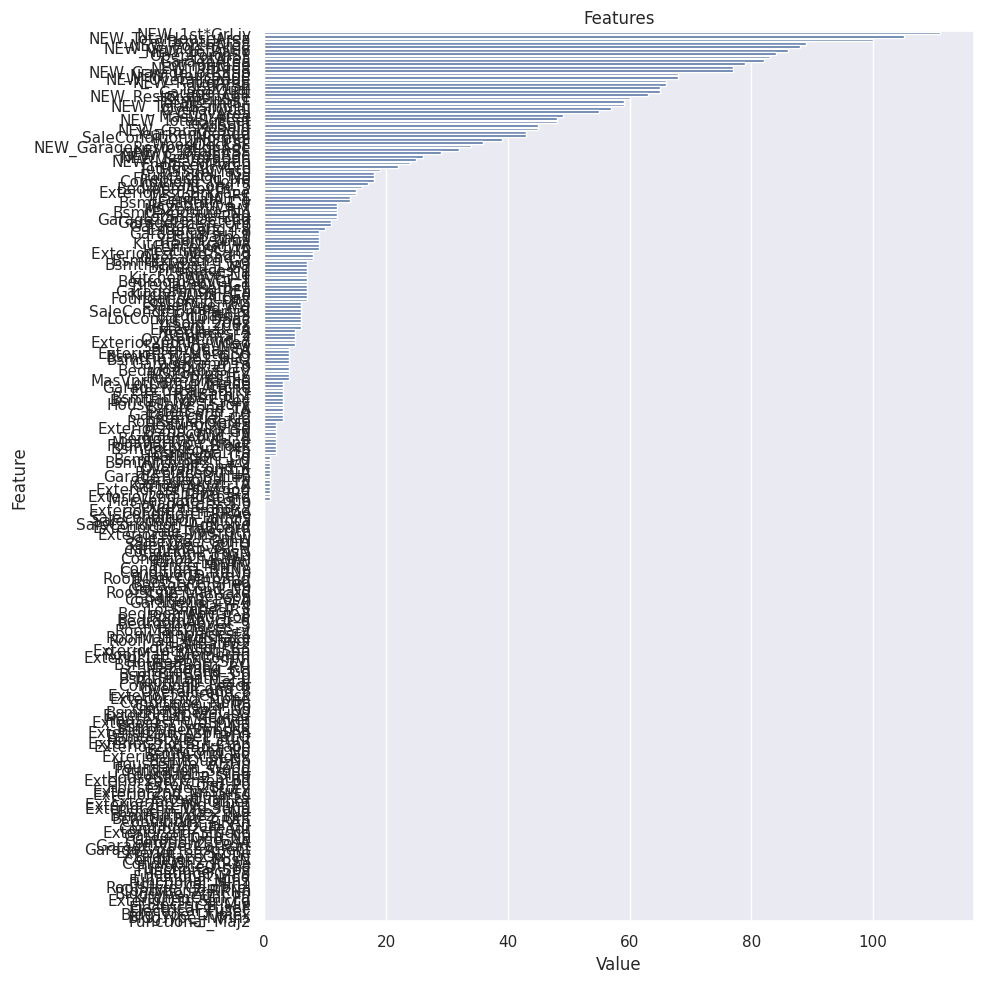

In [115]:
plot_importance(model, X)

In [116]:
################################################################################################################################################
# Test dataframe'indeki boş olan SalePrice değişkenlerini tahminleyiniz ve Kaggle sayfasına submit etmeye uygun halde bir dataframe oluşturunuz.
################################################################################################################################################

In [117]:
model = LGBMRegressor()
model.fit(X,y)
predictions = model.predict(test_df.drop(["Id","SalePrice"], axis=1))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6810
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 182
[LightGBM] [Info] Start training from score 12.024057


In [118]:
dictionary = {"Id": test_df.index, "SalePrice": predictions}
dfSubmission = pd.DataFrame(dictionary)
dfSubmission.to_csv("housePricePredictions.csv", index=False)